## Introduction and Objective

The core objective of this analysis is to evaluate the effectiveness of personalized coupon campaigns in driving higher redemption rates compared to non-personalized campaigns. We hypothesize that personalized coupons, which are tailored to the individual preferences and behaviors of customers, lead to higher redemption rates than standard, non-personalized coupons.

This hypothesis will be tested using data from four distinct datasets, each offering a unique perspective on the customers, their demographics, the coupons issued, and their redemption patterns.

### Datasets Overview

1. **Campaign Table (`campaign_table.csv`)**:
   - **Purpose**: Contains information on the type of coupon campaign and the households targeted.
   - **Fields**: `DESCRIPTION` (type of campaign), `household_key` (unique identifier for each household), `CAMPAIGN` (campaign identifier).
   - **Shape**: 7208 rows × 3 columns.

2. **Household Demographics (`hh_demographic.csv`)**:
   - **Purpose**: Provides demographic information about the households, such as age, marital status, income, and homeownership.
   - **Fields**: `AGE_DESC`, `MARITAL_STATUS_CODE`, `INCOME_DESC`, `HOMEOWNER_DESC`, `HH_COMP_DESC` (household composition), `HOUSEHOLD_SIZE_DESC`, `KID_CATEGORY_DESC`, `household_key`.
   - **Shape**: 801 rows × 8 columns.

3. **Coupons Issued (`coupon.csv`)**:
   - **Purpose**: Lists the coupons that were issued as part of various campaigns.
   - **Fields**: `COUPON_UPC` (coupon code), `PRODUCT_ID`, `CAMPAIGN`.
   - **Shape**: 124548 rows × 3 columns.

4. **Coupon Redemption (`coupon_redempt.csv`)**:
   - **Purpose**: Tracks which of the issued coupons were actually redeemed.
   - **Fields**: `household_key`, `DAY` (the day the coupon was redeemed), `COUPON_UPC`, `CAMPAIGN`.
   - **Shape**: 2318 rows × 4 columns.

In the following sections, we will delve into a comprehensive analysis, merging these datasets to create a unified view of the coupon campaign's impact on customer behavior. We will utilize statistical methods to validate our hypothesis and derive actionable insights that can shape future marketing strategies.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

coupon_hh = pd.read_csv("/mnt/c/Users/Aluminum/Documents/DS Projects 23'/Kaggle/AB_testing/full_data/campaign_table.csv");coupon_hh.head(), coupon_hh.shape

(  DESCRIPTION  household_key  CAMPAIGN
 0       TypeA             17        26
 1       TypeA             27        26
 2       TypeA            212        26
 3       TypeA            208        26
 4       TypeA            192        26,
 (7208, 3))

In [10]:
hh_demo = pd.read_csv("/mnt/c/Users/Aluminum/Documents/DS Projects 23'/Kaggle/AB_testing/full_data/hh_demographic.csv"); hh_demo.head(), hh_demo.shape

(  AGE_DESC MARITAL_STATUS_CODE INCOME_DESC HOMEOWNER_DESC      HH_COMP_DESC  \
 0      65+                   A      35-49K      Homeowner  2 Adults No Kids   
 1    45-54                   A      50-74K      Homeowner  2 Adults No Kids   
 2    25-34                   U      25-34K        Unknown     2 Adults Kids   
 3    25-34                   U      75-99K      Homeowner     2 Adults Kids   
 4    45-54                   B      50-74K      Homeowner     Single Female   
 
   HOUSEHOLD_SIZE_DESC KID_CATEGORY_DESC  household_key  
 0                   2      None/Unknown              1  
 1                   2      None/Unknown              7  
 2                   3                 1              8  
 3                   4                 2             13  
 4                   1      None/Unknown             16  ,
 (801, 8))

In [11]:
coupons = pd.read_csv("/mnt/c/Users/Aluminum/Documents/DS Projects 23'/Kaggle/AB_testing/full_data/coupon.csv"); coupons.head(), coupons.shape

(    COUPON_UPC  PRODUCT_ID  CAMPAIGN
 0  10000089061       27160         4
 1  10000089064       27754         9
 2  10000089073       28897        12
 3  51800009050       28919        28
 4  52100000076       28929        25,
 (124548, 3))

In [12]:
coupon_redempt = pd.read_csv("/mnt/c/Users/Aluminum/Documents/DS Projects 23'/Kaggle/AB_testing/full_data/coupon_redempt.csv"); coupon_redempt.head(), coupon_redempt.shape

(   household_key  DAY   COUPON_UPC  CAMPAIGN
 0              1  421  10000085364         8
 1              1  421  51700010076         8
 2              1  427  54200000033         8
 3              1  597  10000085476        18
 4              1  597  54200029176        18,
 (2318, 4))

## Calculation of Redemption Rates

The initial step in our causal analysis involves setting up the data to calculate the redemption rates for personalized (TypeA) and non-personalized (TypeB and TypeC) coupons. The objective is to understand the effectiveness of each coupon type in terms of its redemption.

### Logic and Setup

To effectively measure the impact of personalized versus non-personalized coupons, we need to quantify the redemption behavior of households. This involves several steps:

1. **Identifying Coupon Types:** We categorize coupons into personalized (TypeA) and non-personalized (TypeB and TypeC) groups. This categorization is critical as it allows us to measure the redemption rates corresponding to each group separately.

2. **Tracking Coupons Sent and Redeemed:** For each household, we track the number of coupons sent and the number redeemed. This is done by joining the `coupon_hh` table with the `coupon_redempt` table based on campaigns. This step is vital to calculate the redemption rate accurately.

3. **Aggregating Redemption Data:** We group redemption data by `household_key` to count the number of redemptions per household. This aggregated view simplifies the calculation of redemption rates.

4. **Handling Missing Data:** We fill in missing redemption counts with zeros to ensure that households with no redemptions are accounted for in our analysis.

5. **Calculating Redemption Rates:** The redemption rate is calculated as the number of redemptions divided by the number of coupons sent. This rate is a crucial metric, indicating the likelihood of coupon redemption for each household.

6. **Merging Demographic Data:** We incorporate demographic information from the `hh_demo` table to enrich our analysis. This data may provide insights into factors influencing redemption behaviors.

7. **Data Cleaning:** We remove duplicate rows to ensure the uniqueness of data points in our analysis.

### Importance in Causal Analysis

By establishing the redemption rates for each type of coupon, we create a foundation for comparing the effectiveness of personalized and non-personalized coupon campaigns. This comparison is the crux of our causal question: Does personalization in coupon campaigns lead to higher redemption rates? The calculated redemption rates serve as a basis for further statistical testing and causal inference.

The careful construction of this dataset ensures that our analysis is grounded in accurate, household-level behavioral data, allowing us to draw more reliable conclusions about the causal impact of coupon personalization.


In [13]:
import pandas as pd

def calculate_redemption_rates(coupon_hh, coupon_redempt, coupons, hh_demo):
    # Type A calculations
    type_a_households = coupon_hh[coupon_hh['DESCRIPTION'] == 'TypeA'][['household_key', 'CAMPAIGN']].drop_duplicates()
    type_a_redemptions = coupon_redempt[coupon_redempt['CAMPAIGN'].isin(type_a_households['CAMPAIGN'])]
    type_a_redemptions_agg = type_a_redemptions.groupby('household_key').size().reset_index(name='redemptions')
    type_a_redemptions_merged = type_a_households.merge(type_a_redemptions_agg, on='household_key', how='left')
    type_a_redemptions_merged['redemptions'].fillna(0, inplace=True)
    type_a_redemptions_merged['coupons_sent_type_a'] = 16
    type_a_redemptions_merged['redemption_rate_type_a'] = type_a_redemptions_merged['redemptions'] / type_a_redemptions_merged['coupons_sent_type_a']
    
    # Type B and C calculations
    type_bc_campaigns = coupon_hh[coupon_hh['DESCRIPTION'].isin(['TypeB', 'TypeC'])][['household_key', 'CAMPAIGN']].drop_duplicates()
    coupons_sent_per_campaign = coupons.groupby('CAMPAIGN')['COUPON_UPC'].nunique().reset_index(name='unique_coupons_sent')
    type_bc_households_with_coupons = type_bc_campaigns.merge(coupons_sent_per_campaign, on='CAMPAIGN', how='left')
    redemptions_agg = coupon_redempt.groupby(['household_key', 'CAMPAIGN'])['COUPON_UPC'].count().reset_index(name='redemptions')
    type_bc_redemption_rate = type_bc_households_with_coupons.merge(redemptions_agg, on=['household_key', 'CAMPAIGN'], how='left')
    type_bc_redemption_rate['redemptions'].fillna(0, inplace=True)
    type_bc_redemption_rate['redemption_rate_type_bc'] = type_bc_redemption_rate['redemptions'] / type_bc_redemption_rate['unique_coupons_sent']
    
    # Merge demographic data
    merged_data = pd.merge(coupon_hh, hh_demo, on="household_key", how="inner")
    
    # Merge redemption rates
    merged_data = pd.merge(merged_data, type_a_redemptions_merged[['household_key', 'redemption_rate_type_a', 'coupons_sent_type_a']], on='household_key', how='left')
    merged_data = pd.merge(merged_data, type_bc_redemption_rate[['household_key', 'redemption_rate_type_bc', 'unique_coupons_sent']], on='household_key', how='left', suffixes=('', '_type_bc'))

    # dropping duplicate rows
    merged_data.drop_duplicates(inplace=True)
    
    return merged_data

merged_df = calculate_redemption_rates(coupon_hh, coupon_redempt, coupons, hh_demo); merged_df.head(), merged_df.shape

(   DESCRIPTION  household_key  CAMPAIGN AGE_DESC MARITAL_STATUS_CODE  \
 0        TypeA             17        26      65+                   B   
 5        TypeA             17        30      65+                   B   
 10       TypeA             17         8      65+                   B   
 15       TypeA             17        13      65+                   B   
 20       TypeA             17        18      65+                   B   
 
    INCOME_DESC HOMEOWNER_DESC      HH_COMP_DESC HOUSEHOLD_SIZE_DESC  \
 0    Under 15K      Homeowner  2 Adults No Kids                   2   
 5    Under 15K      Homeowner  2 Adults No Kids                   2   
 10   Under 15K      Homeowner  2 Adults No Kids                   2   
 15   Under 15K      Homeowner  2 Adults No Kids                   2   
 20   Under 15K      Homeowner  2 Adults No Kids                   2   
 
    KID_CATEGORY_DESC  redemption_rate_type_a  coupons_sent_type_a  \
 0       None/Unknown                     0.0           

## Introduction to Treatment and Control Groups

In the pursuit of answering our causal question, it is imperative to establish clear treatment and control groups. This segmentation enables us to compare outcomes between households that received personalized coupons (treatment) and those that received non-personalized coupons (control).

### Defining Treatment and Control Groups

1. **Identifying Unique Campaign Types:** We first identify the unique campaign types received by each household. This step is crucial to ensure that households are accurately categorized based on the type of coupons they received.

2. **Segregating Households:** We segregate households into the treatment group if they have only received TypeA (personalized) coupons. Conversely, households that have not received TypeA but have received TypeB or TypeC (non-personalized) coupons are designated as the control group. This segregation is vital to maintain the integrity of the analysis by preventing overlap between groups.

3. **Creating Masks:** Using the identified households, we create masks to filter the merged dataframe, thus forming our treatment and control datasets.

4. **Data Cleaning:** We drop irrelevant columns from each group to prevent data leakage and ensure that each group only contains information relevant to their respective coupon types. We also remove duplicate households to maintain unique data points.

5. **Flagging Groups:** We assign a `treatment_flag` to each household, setting it to 1 for the treatment group and 0 for the control group. This flag will later facilitate the causal analysis.

### Visualization and Significance

We visualize the distribution of households in the treatment and control groups to provide a clear, immediate understanding of the group sizes. This visualization reaffirms the balance or disparity between the groups, which may have implications for the analysis.

### Implications for Causal Analysis

The creation of treatment and control groups is a foundational step in causal analysis. It ensures that each group is exposed to a distinct set of conditions - personalized versus non-personalized coupons - enabling us to isolate the effect of personalization on coupon redemption rates. The meticulous setup of these groups ensures that subsequent analyses, such as matching or statistical testing, are grounded in a well-defined comparison, thereby enhancing the credibility and reliability of our findings.

By the end of this process, we obtain a combined dataset with clearly marked treatment and control groups, ready for further analysis to discern the causal impact of coupon personalization.


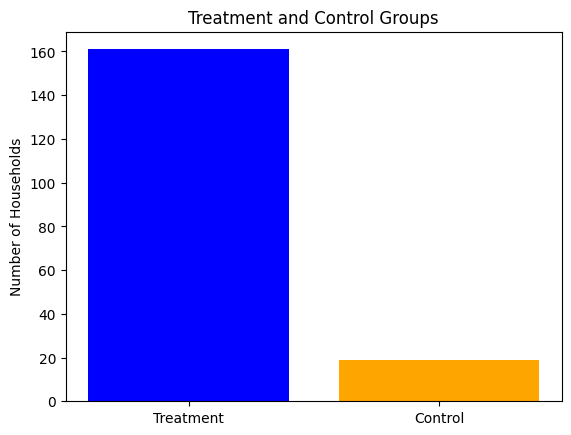

(     DESCRIPTION  household_key  CAMPAIGN AGE_DESC MARITAL_STATUS_CODE  \
 0          TypeA             17        26      65+                   B   
 1205       TypeA           2420        26    45-54                   U   
 6728       TypeA           2182        26    45-54                   A   
 6744       TypeA           2069        26    35-44                   U   
 6753       TypeA           2063        26    55-64                   A   
 
      INCOME_DESC HOMEOWNER_DESC      HH_COMP_DESC HOUSEHOLD_SIZE_DESC  \
 0      Under 15K      Homeowner  2 Adults No Kids                   2   
 1205      15-24K        Unknown     2 Adults Kids                   3   
 6728      75-99K      Homeowner  2 Adults No Kids                   2   
 6744      15-24K        Unknown     Single Female                   1   
 6753      75-99K      Homeowner  2 Adults No Kids                   2   
 
      KID_CATEGORY_DESC  redemption_rate_type_a  coupons_sent_type_a  \
 0         None/Unknown       

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def create_treatment_control_groups(merged_df):
    # Group by household and get unique descriptions for each household
    campaign_types_per_hh = merged_df.groupby('household_key')['DESCRIPTION'].unique()
    
    # Identify households that only received TypeA (treatment) and those that received only TypeB or TypeC (control)
    treatment_hh = campaign_types_per_hh[campaign_types_per_hh.apply(lambda x: set(x) == {'TypeA'})].index
    control_hh = campaign_types_per_hh[campaign_types_per_hh.apply(lambda x: ('TypeA' not in x) and ('TypeB' in x or 'TypeC' in x))].index
    
    # Apply the masks to merged_df to create treatment and control groups
    treatment_group = merged_df[merged_df['household_key'].isin(treatment_hh)]
    control_group = merged_df[merged_df['household_key'].isin(control_hh)]

    # Drop specified columns from control and treatment groups
    treatment_group = treatment_group.drop(columns=['redemption_rate_type_bc', 'unique_coupons_sent'])
    control_group = control_group.drop(columns=['redemption_rate_type_a', 'coupons_sent_type_a'])

    # Dropping duplicate rows based on 'household_key'
    treatment_group = treatment_group.drop_duplicates(subset='household_key')
    control_group = control_group.drop_duplicates(subset='household_key')

    treatment_group['treatment_flag'] = 1
    control_group['treatment_flag'] = 0
    combined_df = pd.concat([treatment_group, control_group], sort=False)

    fig, ax = plt.subplots()
    ax.bar(['Treatment', 'Control'], [len(treatment_group), len(control_group)], color=['blue', 'orange'])
    ax.set_ylabel('Number of Households')
    ax.set_title('Treatment and Control Groups')
    plt.show()
    
    return combined_df, treatment_group, control_group

df,treatment_group, control_group = create_treatment_control_groups(merged_df)

df.head(), df.shape

## Visualization of Treatment and Control Group Redemption Rates

Before delving into more sophisticated causal inference techniques such as matching, it's instructive to visualize the distributions of redemption rates for the treatment and control groups. This initial exploration provides a sense of the data and any apparent differences between the two groups.

### Distributions of Redemption Rates

We employ bootstrapping to estimate the distribution of mean redemption rates for both the treatment group (who received personalized coupons) and the control group (who received non-personalized coupons). The goal is to understand how the central tendency and variability of redemption rates compare between these two groups.

The following visualization presents the kernel density estimate (KDE) plots for the bootstrapped means of the redemption rates:

- **Treatment Group**: Households that exclusively received personalized coupons.
- **Control Group**: Households that received only non-personalized coupons.

For each group, we've also plotted:

- The mean redemption rate (dashed line).
- A shaded area representing two standard deviations from the mean, which approximates the 95% confidence interval of the bootstrapped means.

### Observations

From the KDE plots, we observe the following:

- The **treatment group** shows a distribution of mean redemption rates with a long right tail, indicating that while most households have a redemption rate close to the mean, a small number of households redeem coupons at a much higher rate.
- The **control group** exhibits a high density of households around the mean redemption rate, with some multimodality indicating possible subgroups within the control group behaving differently.

### Statistical Significance

Although there appears to be a difference in the redemption rates between the two groups, we must be cautious in drawing conclusions solely based on this visual analysis. Such apparent differences might not hold up under a rigorous statistical test, which we will perform in the subsequent sections of our analysis.

In the next section, we will employ **propensity score matching** to create comparable treatment and control groups based on observable characteristics. This will allow us to assess the causal effect of personalized coupons on redemption rates more rigorously.


/tmp/ipykernel_21003/4014779541.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(bootstrap_means['Treatment'], shade=True, label='Treatment')
/tmp/ipykernel_21003/4014779541.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(bootstrap_means['Control'], shade=True, label='Control')


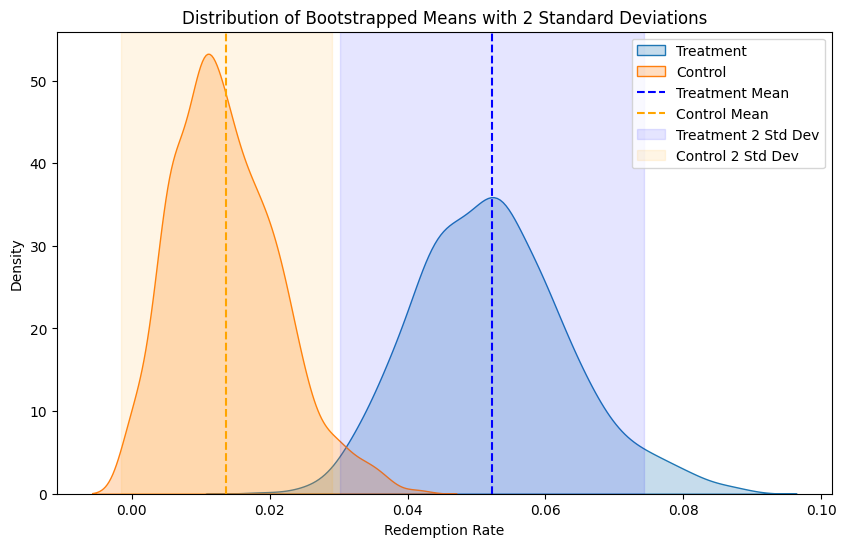

Treatment: Mean = 0.0522, Std Dev = 0.0110
Control: Mean = 0.0137, Std Dev = 0.0076


In [15]:
import seaborn as sns

def plot_with_confidence_intervals(combined_df, n_bootstraps=1000, ci=95):
    # Split the data into treatment and control groups
    treatment_data = combined_df[combined_df['treatment_flag'] == 1]['redemption_rate_type_a'].dropna()
    control_data = combined_df[combined_df['treatment_flag'] == 0]['redemption_rate_type_bc'].dropna()

    # Prepare the bootstrap samples
    bootstrap_means = {
        'Treatment': [],
        'Control': []
    }
    
    for _ in range(n_bootstraps):
        # Treatment bootstrap sample
        treatment_sample = np.random.choice(treatment_data, size=len(treatment_data), replace=True)
        bootstrap_means['Treatment'].append(np.mean(treatment_sample))
        
        # Control bootstrap sample
        control_sample = np.random.choice(control_data, size=len(control_data), replace=True)
        bootstrap_means['Control'].append(np.mean(control_sample))
    
    # Calculate the mean and standard deviation of the bootstrapped means
    treatment_mean = np.mean(bootstrap_means['Treatment'])
    treatment_std = np.std(bootstrap_means['Treatment'])
    control_mean = np.mean(bootstrap_means['Control'])
    control_std = np.std(bootstrap_means['Control'])

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.kdeplot(bootstrap_means['Treatment'], shade=True, label='Treatment')
    sns.kdeplot(bootstrap_means['Control'], shade=True, label='Control')
    
    plt.axvline(x=treatment_mean, color='blue', linestyle='--', label='Treatment Mean')
    plt.axvline(x=control_mean, color='orange', linestyle='--', label='Control Mean')

    # Plot the 2 standard deviations from the mean
    plt.axvspan(treatment_mean - 2 * treatment_std, treatment_mean + 2 * treatment_std, color='blue', alpha=0.1, label='Treatment 2 Std Dev')
    plt.axvspan(control_mean - 2 * control_std, control_mean + 2 * control_std, color='orange', alpha=0.1, label='Control 2 Std Dev')

    plt.title(f'Distribution of Bootstrapped Means with 2 Standard Deviations')
    plt.xlabel('Redemption Rate')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    return {
        'Treatment': {
            'Mean': treatment_mean,
            'Std Dev': treatment_std
        },
        'Control': {
            'Mean': control_mean,
            'Std Dev': control_std
        }
    }

# Usage
statistics = plot_with_confidence_intervals(df)

# Output the statistics
for group, stats in statistics.items():
    print(f"{group}: Mean = {stats['Mean']:.4f}, Std Dev = {stats['Std Dev']:.4f}")


In [12]:
import seaborn as sns

def plot_distribution_comparison(treatment_group, control_group, t_column_name, c_column_name):
    # Prepare data: Select the redemption rate column for treatment and control groups
    treatment_data = treatment_group[t_column_name].dropna()
    control_data = control_group[c_column_name].dropna()
    
    # Create figure and axis
    plt.figure(figsize=(10, 6))
    
    # Plot the distribution of redemption rates for both groups
    sns.kdeplot(treatment_data, shade=True, label='Treatment', color='blue')
    sns.kdeplot(control_data, shade=True, label='Control', color='orange')
    
    # Customization of the plot
    plt.title('Comparison of Redemption Rate Distributions')
    plt.xlabel('Redemption Rate')
    plt.ylabel('Density')
    plt.legend()
    
    # Display the plot
    plt.show()


## Matching in Observational Studies

In observational studies, where randomized control trials are not feasible, matching is a statistical technique used to create a pseudo-randomized control group. It allows us to control for confounding variables and reduce selection bias by matching treated units with untreated units that have similar characteristics.

### The Role of Propensity Scores

Propensity scores play a pivotal role in this process. They are the probability of receiving the treatment given the observed covariates. Mathematically, the propensity score $ e(X) $ for a unit with covariates  $ X $ is defined as:

$$
e(X) = P(T = 1 | X)
$$

where $ T $ is the treatment indicator.

### Nearest Neighbor Matching

Nearest Neighbor Matching is a method of matching treated units to untreated units based on the closest propensity score, effectively pairing units with similar likelihoods of receiving the treatment. This method aims to mimic the balance of covariates that one would expect from a randomized experiment.

### Implementing Matching

We implement Nearest Neighbor Matching using the following steps:

1. **Dummy Coding:** We convert categorical variables to dummy variables to facilitate the matching process on a comparable scale.

2. **Propensity Score Estimation:** A logistic regression model is trained to estimate the propensity score, $ \hat{e}(X) $, for each unit.


3. **Matching:** With the estimated propensity scores, we perform the matching. Each treated unit is matched with one or more untreated units with the nearest propensity scores, within a caliper if specified.

### Rationale Behind the Approach

The rationale behind using propensity score matching includes:

- **Reduction of Bias:** By matching on propensity scores, we reduce bias due to confounding variables that are related to both the treatment assignment and the outcome.
- **Improving Causal Inference:** Matching helps in creating a more comparable control group, which improves the validity of causal inference.
- **Flexibility:** Propensity score matching can be tailored to the study's needs, for example, by choosing between matching with or without replacement, or by selecting an appropriate caliper.

### Practical Implementation

In our analysis, we utilize the `NearestNeighborMatch` class from the `causalml` library, which provides a robust framework for conducting propensity score matching. The `LogisticRegression` model from `sklearn` estimates the propensity scores, and the matching is executed based on these scores.


By the end of the matching process, we have a dataset of matched treatment and control units, which significantly resembles the conditions of a randomized controlled trial, thereby laying a solid foundation for subsequent causal effect estimation.



In [30]:
import pandas as pd
from causalml.match import NearestNeighborMatch
from sklearn.linear_model import LogisticRegression

def perform_matching(df, covariates, treatment_col):
    # Convert categorical variables to dummies
    df_with_dummies = pd.get_dummies(df[covariates + [treatment_col]], drop_first=True)

    # Define the covariate columns
    covariate_cols = df_with_dummies.columns.drop(treatment_col)

    # Perform nearest neighbor matching
    nn_match = NearestNeighborMatch(replace=False, ratio=1, random_state=42)
    propensity_model = LogisticRegression()
    propensity_model.fit(df_with_dummies[covariate_cols], df_with_dummies[treatment_col])

    # Predict the propensity score
    df_with_dummies['propensity_score'] = propensity_model.predict_proba(df_with_dummies[covariate_cols])[:, 1]

    # Now, use the propensity scores for matching
    matched_df = nn_match.match(
        data=df_with_dummies,
        treatment_col=treatment_col,
        score_cols=['propensity_score']
    )

    return matched_df

matched_df = perform_matching(df, ['AGE_DESC', 'MARITAL_STATUS_CODE', 'INCOME_DESC', 'HOMEOWNER_DESC', 'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC'], 'treatment_flag')
matched_df.head(), matched_df.shape

(       treatment_flag  AGE_DESC_25-34  AGE_DESC_35-44  AGE_DESC_45-54  \
 53480               1               1               0               0   
 54225               1               0               0               1   
 57167               1               0               0               0   
 50370               1               0               0               1   
 35303               1               1               0               0   
 
        AGE_DESC_55-64  AGE_DESC_65+  MARITAL_STATUS_CODE_B  \
 53480               0             0                      1   
 54225               0             0                      0   
 57167               0             1                      0   
 50370               0             0                      0   
 35303               0             0                      1   
 
        MARITAL_STATUS_CODE_U  INCOME_DESC_125-149K  INCOME_DESC_15-24K  ...  \
 53480                      0                     0                   0  ...   
 54225        

### Calculating Average Outcomes and Business Implications

The function `calculate_average_outcomes` serves to evaluate the impact of the personalized coupon campaign by determining the average redemption rates within our matched treatment and control groups.

**Results:**
- **Average outcome for Type A with treatment (personalized coupons):** \( 0.0833 \)
- **Average outcome for Type B and C without treatment (non-personalized coupons):** \( 0.0146 \)

**Interpretation:**
The average redemption rate for households that received personalized coupons (Type A) is approximately \( 0.0833 \), or \( 8.33\% \). In contrast, the redemption rate for households that did not receive personalized coupons (Type B and C) is about \( 0.0146 \), or \( 1.46\% \).

From a business perspective, these figures suggest that personalized coupons are significantly more effective at driving coupon redemptions than non-personalized ones. Specifically, the personalized approach appears to increase the likelihood of redemption by nearly \( 5.7 \) times compared to the non-personalized approach.

This insight can inform marketing strategies by highlighting the value of investing in personalized marketing efforts. Businesses could allocate more resources towards developing personalized campaigns to boost customer engagement and increase the effectiveness of promotional activities.


In [1]:
def calculate_average_outcomes(df, matched_df):
    # Filter the DataFrame
    filtered_df = df.loc[matched_df.index]

    # Ensure the dataset has the necessary columns
    analysis_df = filtered_df[['treatment_flag', 'redemption_rate_type_a', 'redemption_rate_type_bc']]

    # Calculate and print the average outcomes for Type A with treatment
    average_outcome_type_a = analysis_df[analysis_df['treatment_flag'] == 1]['redemption_rate_type_a'].mean()
    print(f'Average outcome for Type A with treatment: {average_outcome_type_a}')

    # Calculate and print the average outcomes for Type B and C without treatment
    average_outcome_type_bc = analysis_df[analysis_df['treatment_flag'] == 0]['redemption_rate_type_bc'].mean()
    print(f'Average outcome for Type B and C without treatment: {average_outcome_type_bc}')

    return analysis_df

analysis_df = calculate_average_outcomes(df, matched_df)

NameError: name 'df' is not defined

## Hypothesis Formulation

To quantitatively assess the effectiveness of personalized coupon campaigns versus non-personalized campaigns, we will test the following hypotheses:

### Null Hypothesis ($H_0$):
There is no significant difference in the redemption rates of personalized and non-personalized coupons. Mathematically, we can express this as:

$$
H_0: \mu_{\text{personalized}} = \mu_{\text{non-personalized}}
$$

where $\mu$ represents the mean redemption rate.

### Alternative Hypothesis ($H_1$):
Personalized coupon campaigns result in a significantly different redemption rate compared to non-personalized campaigns, which we express as:

$$
H_1: \mu_{\text{personalized}} \neq \mu_{\text{non-personalized}}
$$

To test this hypothesis, we will conduct statistical tests to compare the mean redemption rates between the two groups. If the p-value is less than the chosen significance level, we will reject the null hypothesis in favor of the alternative hypothesis, indicating that there is a significant difference in redemption rates.

In [32]:
import numpy as np
import pandas as pd
from scipy import stats

def perform_statistical_tests():

    analysis_df = calculate_average_outcomes(df, matched_df)
    
    # Separate the two groups, dropping NaN values for each group
    personalized_rates = analysis_df[analysis_df['treatment_flag'] == 1]['redemption_rate_type_a'].dropna()
    non_personalized_rates = analysis_df[analysis_df['treatment_flag'] == 0]['redemption_rate_type_bc'].dropna()

    # Check for normality
    # If p-value > 0.05 for both, data follows a normal distribution
    print(stats.shapiro(personalized_rates))
    print(stats.shapiro(non_personalized_rates))

    # If both are normal, use t-test
    # If not, use Mann-Whitney U test
    if stats.shapiro(personalized_rates)[1] > 0.05 and stats.shapiro(non_personalized_rates)[1] > 0.05:
        t_stat, p_value = stats.ttest_ind(personalized_rates, non_personalized_rates, equal_var=False)
        print("Using t-test")
    else:
        u_stat, p_value = stats.mannwhitneyu(personalized_rates, non_personalized_rates, alternative='two-sided')
        print("Using Mann-Whitney U test")

    # Check the p-value to determine the significance
    if p_value < 0.05:
        print("Reject the null hypothesis: There is a significant difference in redemption rates.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference in redemption rates.")

    # Print the results
    print(f"Statistic: {t_stat if 't_stat' in locals() else u_stat}, p-value: {p_value}")

# Call the function
perform_statistical_tests()



Average outcome for Type A with treatment: 0.08333333333333333
Average outcome for Type B and C without treatment: 0.014550264550264548
ShapiroResult(statistic=0.42958658933639526, pvalue=2.0781106968570384e-07)
ShapiroResult(statistic=0.4779896140098572, pvalue=5.193282959226053e-07)
Using Mann-Whitney U test
Fail to reject the null hypothesis: There is no significant difference in redemption rates.
Statistic: 185.5, p-value: 0.3173431779128052


## Conclusion

Our analysis aimed to test the effectiveness of personalized coupon campaigns compared to non-personalized ones. By formulating and testing a hypothesis using statistical methods, we sought to determine whether personalized campaigns significantly increase coupon redemption rates.

### Statistical Test Results

After calculating the average outcomes for both the treatment and control groups, we conducted normality tests on the redemption rates. The results of the Shapiro-Wilk test indicated that the data did not follow a normal distribution, necessitating the use of the Mann-Whitney U test over the t-test.

**Mann-Whitney U Test Findings:**
- **Statistic:** 185.5
- **P-value:** 0.3173

### Interpretation of Findings

With a p-value greater than the conventional alpha level of 0.05, we fail to reject the null hypothesis. This result suggests that there is no statistically significant difference in the redemption rates of personalized versus non-personalized coupons within our matched dataset.

### Business Implications

These findings are critical for decision-making in marketing strategy. Despite the initial indication that personalized coupons had a higher average redemption rate, the statistical test reveals that, when considering the matched samples, the difference is not statistically significant.

This suggests that while personalized marketing may seem more effective in some cases, it may not always lead to a measurable increase in coupon redemptions when tested under rigorous statistical frameworks. Companies should consider this outcome when allocating resources to personalized marketing campaigns and may want to explore additional factors that could influence the effectiveness of these campaigns or reassess the methods of personalization being employed.

### Next Steps

Given these insights, it may be beneficial to:
- Conduct further analysis with a larger sample size or different matching criteria to validate these findings.
- Explore other potential benefits of personalized marketing, such as customer satisfaction or long-term value, which might not be captured solely by redemption rates.
- Consider a multifaceted approach to coupon campaigns, combining personalization with other marketing strategies to enhance overall effectiveness.
